In [1]:
# Set up sys.path and import needed packages.
import _preamble

import numpy as np
from scipy.integrate import fixed_quad
from scipy.special import jv
import matplotlib.pyplot as plt

from pmte import estimation, tapers, util
import helpers

In [2]:
# Set basic parameters.
N = 128  # Size of images
M = 200  # Number of images

# Initialize PRNG.
rng = np.random.default_rng(0)

In [3]:
# Define the power spectral density (PSD) that will be used to generate the
# noisy images. This corresponds to S(ξ) in eq. (6.1) of the paper, but with a
# normalizing factor to ensure that S(0) = 1.

def psd_fun(xi1, xi2):
    # The integral in eq. (6.1) is approximated with a Gauss–Legendre
    # quadrature rule over the interval [0, 100] with 200 nodes.
    quadrature = lambda func: fixed_quad(func, 0, 100, n=200)[0]

    integrand = lambda u, xi: (
        jv(0, 8 * np.expand_dims(xi, -1) * u) * (jv(1, u) / u) ** 3 * u
    )

    xi = np.hypot(xi1, xi2)

    # Calculate normalizing constant.
    C = quadrature(lambda u: integrand(u, 0))

    density = 1 / C * quadrature(lambda u: integrand(u, xi))

    return density

In [4]:
# Generate a n random images of size N×N with the desired PSD.
X = helpers.generate_field((N, N), M, psd_fun=psd_fun, rng=rng)

# Calculate the true PSD on a frequency grid of size N×N.
psd_true = psd_fun(*util.grid((N, N)))

In [5]:
# Define grid of radii for the disk masks.
radii = np.geomspace(2 ** -4 * N, 2 ** -1 * N, 3 * 4 + 1)

In [6]:
# Estimate the spectral estimation error for masks of various radii with a
# bandwidth that is asymptotically optimal for that mask.
errors = []
n_masks = []

for radius in radii:
    # Generate a mask of radius r.
    mask = helpers.disk_mask(N, radius)

    # Compute the asymptotically optimal bandwidth for this mask (see comment
    # after eq. (4.4) in the paper).
    n_mask = np.count_nonzero(mask)
    W = n_mask ** (-1 / 6)

    # Generate proxy tapers for the desired mask and bandwidths.
    h = tapers.proxy_tapers(mask, W, rng=rng)

    # Computer the multitaper estimator for the proxy tapers.
    psd_est = estimation.multitaper(X, h)

    # Approximate the maximum mean squared error using an empirical average as
    # in eq. (6.2) of the paper.
    error = np.max(np.mean(np.abs(psd_true - psd_est) ** 2, axis=0))

    errors.append(error)
    n_masks.append(n_mask)

# Convert to ndarrays for processing.
errors = np.array(errors)
n_masks = np.array(n_masks)

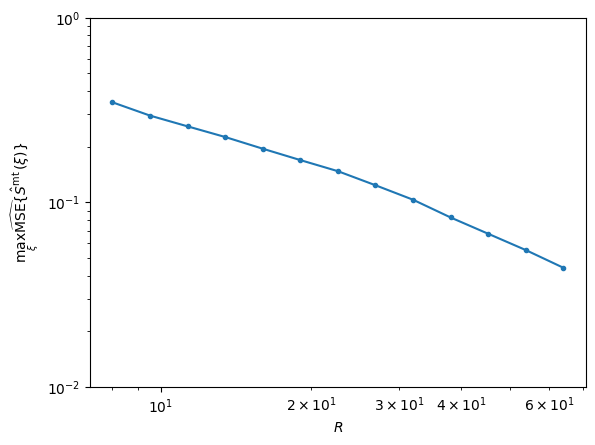

In [7]:
# Plot Figure 4(b) in paper.
plt.loglog(radii, errors, ".-")
plt.xlabel("$R$")
plt.ylabel(r"$\max_\xi \widehat{\mathrm{MSE}}\{\hat{S}^{\mathrm{mt}}(\xi)\}$")
plt.yticks([1e-2, 1e-1, 1e0])
plt.show(block=False)

In [8]:
# Estimate the slope in the log–log plot after normalizing by log^2(n_mask).
# According to the theorem, the error should decay as R^{–4/3}.
beta = helpers.log_slope(radii, errors / np.log(n_masks) ** 2)

print("Estimated exponent: %f" % (beta,))

Estimated exponent: -1.526300


---

In [9]:
# Save data for figure generation.
helpers.save_table("mse2_single", radii, errors)

results = {"beta": float(beta)}

helpers.save_dictionary("mse2_single", results)